# Parcels environment : base

In [1]:
import parcels
import numpy as np
from datetime import timedelta
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import os

def u2rho_2d (var_u):
    [Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[:,1:L-1]=0.5*(var_u[:,0:Lm-1]+var_u[:,1:L-1])
    var_rho[:,0]=var_rho[:,1]
    var_rho[:,Lp-1]=var_rho[:,-2]
    return var_rho
    
def v2rho_2d (var_v):
    [M,Lp]=var_v.shape
    Mp=M+1
    Mm=M-1
    var_rho=np.zeros((Mp,Lp))
    var_rho[1:M-1,:]=0.5*(var_v[0:Mm-1,:]+var_v[1:M-1,:])
    var_rho[0,:]=var_rho[1,:]
    var_rho[Mp-1,:]=var_rho[-2,:]
    return var_rho

def u2rho_3d (var_u):
    [N,Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=np.zeros((N,Mp,Lp))
    var_rho[:,:,1:L-1]=0.5*(var_u[:,:,0:Lm-1]+var_u[:,:,1:L-1])
    var_rho[:,:,0]=var_rho[:,:,1]
    var_rho[:,:,Lp-1]=var_rho[:,:,-2]
    return var_rho
    
def v2rho_3d (var_v):
    [N,M,Lp]=var_v.shape
    Mp=M+1
    Mm=M-1
    var_rho=np.zeros((N,Mp,Lp))
    var_rho[:,1:M-1,:]=0.5*(var_v[:,0:Mm-1,:]+var_v[:,1:M-1,:])
    var_rho[:,0,:]=var_rho[:,1,:]
    var_rho[:,Mp-1,:]=var_rho[:,-2,:]
    return var_rho

def spheric_dist(lat1, lat2, lon1, lon2):
    """
    Compute the spherical distance between two points on Earth.
    
    Parameters:
    lat1, lat2 : array-like
        Latitude of the two points (in degrees).
    lon1, lon2 : array-like
        Longitude of the two points (in degrees).
    
    Returns:
    dist : array-like
        The spherical distance between the points (in meters).
    """
    
    # Earth radius in meters
    R = 6367442.76
    
    # Determine proper longitudinal shift
    l = np.abs(lon2 - lon1)
    l[l >= 180] = 360 - l[l >= 180]
    
    # Convert decimal degrees to radians
    deg2rad = np.pi / 180
    lat1 = lat1 * deg2rad
    lat2 = lat2 * deg2rad
    l = l * deg2rad
    
    # Compute the distances
    dist = R * np.arcsin(np.sqrt(((np.sin(l) * np.cos(lat2)) ** 2) + 
                                 ((np.sin(lat2) * np.cos(lat1)) - 
                                  (np.sin(lat1) * np.cos(lat2) * np.cos(l))) ** 2))
    
    return dist

def spheric_dist_one(lat1, lat2, lon1, lon2):
    """计算两个经纬度点之间的球面距离（标量版）"""
    # 处理经度差
    l = np.abs(lon2 - lon1)
    if l >= 180:
        l = 360 - l
    
    # 转换为弧度
    deg2rad = np.pi / 180
    lat1_rad = lat1 * deg2rad
    lat2_rad = lat2 * deg2rad
    l_rad = l * deg2rad
    
    # 球面距离公式
    distance = 6371 * np.arccos(
        np.sin(lat1_rad) * np.sin(lat2_rad) + 
        np.cos(lat1_rad) * np.cos(lat2_rad) * np.cos(l_rad)
    )
    return distance

In [2]:
grid_dir='/meddy/simingzhang/Data/RB_iceland_data/'
wave_dir='/meddy/simingzhang/Data/Parcels_data/'
# nowave_dir='/meddy/simingzhang/Data/RB_iceland_data/iceland_no_wave/'
grdname='niskin2km_500m_grd.nc'
# hisname_w='z_niskin2km_his_hf_depth_500m_grd.0002.nc'
# hisname_nw='z_niskin2km_his_smooth_depth_500m_grd.0002.nc'

grdname=f'{grid_dir}{grdname}'
# wavename=f'{wave_dir}{hisname_w}'
# nowavename=f'{nowave_dir}{hisname_nw}'

wavename=f'{wave_dir}wavecase_modified_cg.nc'
nowavename=f'{wave_dir}nowavecase_modified_cg.nc'


In [3]:
grid=xr.open_dataset(grdname)
grid = grid.swap_dims({'eta_u': 'eta_rho','xi_v':'xi_rho'})

lon_rho=grid['lon_rho']
lat_rho=grid['lat_rho']
h=grid['h']
lonmin=np.min(lon_rho.values)
lonmax=np.max(lon_rho.values)
latmin=np.min(lat_rho.values)
latmax=np.max(lat_rho.values)
lonmin,lonmax,latmin,latmax
grid

<xarray.Dataset> Size: 19MB
Dimensions:    (one: 1, eta_rho: 287, xi_rho: 287, bath: 1, xi_u: 286,
                eta_v: 286, eta_psi: 286, xi_psi: 286)
Dimensions without coordinates: one, eta_rho, xi_rho, bath, xi_u, eta_v,
                                eta_psi, xi_psi
Data variables: (12/34)
    xl         (one) float64 8B ...
    el         (one) float64 8B ...
    depthmin   (one) float64 8B ...
    depthmax   (one) float64 8B ...
    spherical  (one) |S1 1B ...
    angle      (eta_rho, xi_rho) float64 659kB ...
    ...         ...
    lat_v      (eta_v, xi_rho) float64 657kB ...
    lat_psi    (eta_psi, xi_psi) float64 654kB ...
    mask_rho   (eta_rho, xi_rho) float64 659kB ...
    mask_u     (eta_rho, xi_u) float64 657kB ...
    mask_v     (eta_v, xi_rho) float64 657kB ...
    mask_psi   (eta_psi, xi_psi) float64 654kB ...
Attributes:
    title:    Solomon Model
    date:     08-Apr-2018
    type:     ROMS grid file

In [4]:
ds = xr.open_dataset(f'{wave_dir}wavecase.nc')
ds
depth=ds['depth'].values

# transform from C-grid to A-grid
### 1. wave case

In [5]:
ds = xr.open_dataset(f'{wave_dir}wavecase.nc')

ds['lon_rho']=lon_rho
ds['lat_rho']=lat_rho

ds.squeeze(dim='depth')
ds


# ds.to_netcdf(f'{wave_dir}wavecase_modified.nc')

<xarray.Dataset> Size: 2GB
Dimensions:     (depth: 1, time: 2148, eta_rho: 287, xi_u: 286, eta_v: 286,
                 xi_rho: 287)
Coordinates:
  * depth       (depth) float32 4B -2.0
Dimensions without coordinates: time, eta_rho, xi_u, eta_v, xi_rho
Data variables:
    ocean_time  (time) float32 9kB ...
    u           (time, depth, eta_rho, xi_u) float32 705MB ...
    v           (time, depth, eta_v, xi_rho) float32 705MB ...
    w           (time, depth, eta_rho, xi_rho) float32 708MB ...
    lon_rho     (eta_rho, xi_rho) float64 659kB -30.93 -30.89 ... -19.99 -19.95
    lat_rho     (eta_rho, xi_rho) float64 659kB 57.6 57.59 57.59 ... 61.39 61.38
Attributes:
    history:                   Thu Jul 18 14:58:06 2019: ncrcat -d depth,0 z_...
    nco_openmp_thread_number:  1

In [6]:
u_rho = np.zeros(ds['w'].shape)
u_rho[:,0,:,:]=u2rho_3d(np.squeeze(ds['u'].values))
# u_rho[np.abs(u_rho)<1e-3]=np.nan
ds["u_rho"] = (("time", "depth", "eta_rho", "xi_rho"), u_rho)
v_rho = np.zeros(ds['w'].shape)
v_rho[:,0,:,:]=v2rho_3d(np.squeeze(ds['v'].values))
# v_rho[np.abs(v_rho)<1e-3]=np.nan
ds["v_rho"] = (("time", "depth", "eta_rho", "xi_rho"), v_rho)

In [7]:
np.min(np.abs(ds['u'].values)),np.min(np.abs(ds['v'].values))

(2.2161474e-10, 2.093455e-11)

In [8]:
np.min(np.abs(ds.u_rho))

<xarray.DataArray 'u_rho' ()> Size: 8B
array(0.)

In [9]:
ds.to_netcdf(f'{wave_dir}wavecase_modified.nc')

In [10]:
ur=ds.u_rho.values
vr=ds.v_rho.values


In [ ]:
III=85
JJJ=269
time_idx, depth_idx, lat_idx, lon_idx = np.where(np.abs(ur) < 1e-8)

# 创建单个图形
fig, ax = plt.subplots(figsize=(10, 8))

# 绘制pcolormesh
cs = ax.pcolormesh(lon_rho, lat_rho, np.sqrt(np.squeeze(ur[500,0,:,:]**2+vr[500,0,:,:]**2)), 
                  cmap='viridis', shading='gouraud', vmin=0, vmax=1)
ax.plot(lon_rho[10:-10,10], lat_rho[10:-10,10], 'r-', lw=3)  # 左
ax.plot(lon_rho[10:-10,-10], lat_rho[10:-10,-10], 'r-', lw=3)  # 右
ax.plot(lon_rho[10,10:-10], lat_rho[10,10:-10], 'r-', lw=3)  # 下
ax.plot(lon_rho[-10,10:-10], lat_rho[-10,10:-10], 'r-', lw=3)  # 上


# 添加colorbar
cbar = fig.colorbar(cs, ax=ax, orientation='vertical', pad=0.02, shrink=1, extend='both')
for ii in range(lat_idx.shape[0]):
    ax.scatter(lon_rho[lat_idx[ii],lon_idx[ii]],lat_rho[lat_idx[ii],lon_idx[ii]],s=100,c='red', edgecolor='k', alpha=0.8)
plt.show()

In [ ]:
# np.nanmax(ur[500,0,:,:]),np.nanmin(np.abs(ur[500,0,:,:]))
ur = np.where(ur == 0, np.nan, ur)


In [ ]:
np.nanmax(ur),np.nanmin(np.abs(ur))

In [ ]:
ur[np.abs(ur)<1e-4]=np.nan
vr[np.abs(vr)<1e-4]=np.nan

In [ ]:
III=85
JJJ=269
# time_idx, depth_idx, lat_idx, lon_idx = np.where(np.abs(ur) < 1e-8)

# 创建单个图形
fig, ax = plt.subplots(figsize=(10, 8))

# 绘制pcolormesh
cs = ax.pcolormesh(lon_rho, lat_rho, np.sqrt(np.squeeze(ur[500,0,:,:]**2+vr[500,0,:,:]**2)), 
                  cmap='viridis', shading='gouraud', vmin=0, vmax=1)

In [87]:
1232952/2148/2

287.0

# # transform from C-grid to A-grid
### 2. no wave case

In [ ]:
ds = xr.open_dataset(f'{wave_dir}nowavecase.nc')

ds['lon_rho']=lon_rho
ds['lat_rho']=lat_rho

ds.squeeze(dim='depth')
ds

In [ ]:
u_rho = np.zeros(ds['w'].shape)
u_rho[:,0,:,:]=u2rho_3d(np.squeeze(ds['u'].values))
ds["u_rho"] = (("time", "depth", "eta_rho", "xi_rho"), u_rho)
v_rho = np.zeros(ds['w'].shape)
v_rho[:,0,:,:]=v2rho_3d(np.squeeze(ds['v'].values))
ds["v_rho"] = (("time", "depth", "eta_rho", "xi_rho"), v_rho)

In [ ]:
ds.to_netcdf(f'{wave_dir}nowavecase_modified.nc')

# Parcel
### 1. wave case

In [16]:
wavename
filenames = {"U": wavename, "V": wavename,"PI2": wavename,"PI4": wavename,"PI6": wavename,"PI8": wavename,"PI10": wavename,
            "PI12": wavename,"PI16": wavename,"PI20": wavename,"PI30": wavename,"PI50": wavename,"PI60": wavename,"PI100": wavename}
filenames

{'U': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'V': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI2': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI4': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI6': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI8': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI10': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI12': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI16': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI20': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI30': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI50': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI60': '/meddy/simingzhang/Data/Parcels_data/wavecase_modified_cg.nc',
 'PI100': '/meddy/simingzhang/Data/Parcels_data/wavecase_modi

In [17]:
# pip show parcels


In [18]:

variables = {
    "U": "u_rho",
    "V": "v_rho",
    "PI2": "PI2",
    "PI4": "PI4",
    "PI6": "PI6",
    "PI8": "PI8",
    "PI10": "PI10",
    "PI12": "PI12",
    "PI16": "PI16",
    "PI20": "PI20",
    "PI30": "PI30",
    "PI50": "PI50",
    "PI60": "PI60",
    "PI100": "PI100",
}
dimensions = {
    "U": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "V": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI2": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI4": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI6": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI8": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI10": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI12": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI16": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI20": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI30": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI50": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI60": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "PI100": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
}
fieldset = parcels.FieldSet.from_a_grid_dataset(filenames, variables, dimensions,allow_time_extrapolation=True,gridindexingtype="mitgcm")
# ,allow_time_extrapolation=True



In [19]:
fieldset

<FieldSet>
    fields:
        <Field>
            name            : 'U'
            grid            : CurvilinearZGrid(lon=array([[-30.93, -30.89, -30.86, ..., -21.72, -21.69, -21.65],
               [-30.92, -30.89, -30.85, ..., -21.71, -21.68, -21.65],
               [-30.91, -30.88, -30.85, ..., -21.71, -21.68, -21.64],
               ...,
               [-29.14, -29.11, -29.08, ..., -20.03, -20.00, -19.97],
               [-29.13, -29.10, -29.07, ..., -20.02, -19.99, -19.96],
               [-29.13, -29.09, -29.06, ..., -20.02, -19.99, -19.95]], dtype=float32), lat=array([[ 57.60,  57.59,  57.59, ...,  56.71,  56.71,  56.71],
               [ 57.61,  57.61,  57.61, ...,  56.73,  56.73,  56.72],
               [ 57.63,  57.63,  57.62, ...,  56.75,  56.74,  56.74],
               ...,
               [ 62.24,  62.23,  62.23, ...,  61.36,  61.36,  61.35],
               [ 62.25,  62.25,  62.25, ...,  61.37,  61.37,  61.37],
               [ 62.27,  62.26,  62.26, ...,  61.39,  61.39, 

In [20]:
fieldset.U.grid.time *= 3600  # 秒 → 小时
# lonp1.shape

In [21]:
fieldset.U.grid.time/1e9

array([0.0000e+00, 3.6000e-06, 7.2000e-06, ..., 7.7220e-03, 7.7256e-03,
       7.7292e-03])

In [22]:
def DeleteParticle(particle, fieldset, time):
    if (particle.lon < -30.92595646869225+1.5) or (particle.lon > -19.9541352315797-1.5) or \
       (particle.lat < 56.70597152564239+0.5) or (particle.lat > 62.267609501148414-0.5):
        particle.delete()
        
def SampleT(particle, fieldset, time):
    particle.ue = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    particle.ve = fieldset.V[time, particle.depth, particle.lat, particle.lon]
    particle.pi2 = fieldset.PI2[time, particle.depth, particle.lat, particle.lon]
    particle.pi4 = fieldset.PI4[time, particle.depth, particle.lat, particle.lon]
    particle.pi6 = fieldset.PI6[time, particle.depth, particle.lat, particle.lon]
    particle.pi8 = fieldset.PI8[time, particle.depth, particle.lat, particle.lon]
    particle.pi10 = fieldset.PI10[time, particle.depth, particle.lat, particle.lon]
    particle.pi12 = fieldset.PI12[time, particle.depth, particle.lat, particle.lon]
    particle.pi16 = fieldset.PI16[time, particle.depth, particle.lat, particle.lon]
    particle.pi20 = fieldset.PI20[time, particle.depth, particle.lat, particle.lon]
    particle.pi30 = fieldset.PI30[time, particle.depth, particle.lat, particle.lon]
    particle.pi50 = fieldset.PI50[time, particle.depth, particle.lat, particle.lon]
    particle.pi60 = fieldset.PI60[time, particle.depth, particle.lat, particle.lon]
    particle.pi100 = fieldset.PI100[time, particle.depth, particle.lat, particle.lon]

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [23]:
lonp=lon_rho.values
latp=lat_rho.values
# Range=20
# JJ=[Range,287-Range]
# II=[Range,287-Range]
# step=1
# lonp1=lonp[JJ[0]:JJ[1]:step,II[0]:II[1]:step].ravel()
# latp1=latp[JJ[0]:JJ[1]:step,II[0]:II[1]:step].ravel()
step=1
centerpoint=144
# npart=2500
npart=50*50
if (np.sqrt(npart) / 2) % 1 == 0:
    left1=int(np.sqrt(npart)/2)
    right1=int(np.sqrt(npart)/2)
    # print(1)
else:
    left1=int((np.sqrt(npart)+1)/2)
    right1=int((np.sqrt(npart)+1)/2)-1
    # print(2)
II=[centerpoint-left1,centerpoint+right1]
JJ=[centerpoint-left1,centerpoint+right1]
lonp1=lonp[JJ[0]:JJ[1]:step,II[0]:II[1]:step].ravel()
latp1=latp[JJ[0]:JJ[1]:step,II[0]:II[1]:step].ravel()
during=89.5 # days
total_seconds = during * 86400 
outputwavename=f'{wave_dir}wave_pars_P{latp1.shape[0]}T{during}days.zarr'

In [24]:
lonp1.shape

(2500,)

In [25]:
lonp1.shape

(2500,)

In [26]:

# pset = parcels.ParticleSet.from_line(
#     fieldset=fieldset,
#     pclass=parcels.JITParticle,
#     size=1000,
#     start=(-28, 60),
#     finish=(-24, 60),
#     depth=-2,
# )

# ---------------------------------------------------------grid release------------------------------------------------------------
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=parcels.JITParticle.add_variable("ue").add_variable("ve").add_variable("pi2").add_variable("pi4").add_variable("pi6").
    add_variable("pi8").add_variable("pi10").add_variable("pi12").add_variable("pi16").add_variable("pi20").
    add_variable("pi30").add_variable("pi50").add_variable("pi60").add_variable("pi100"),
    lon=lonp1,
    lat=latp1,
    # size=100,                # 粒子总数
    depth=-2*np.ones(lonp1.shape)                  # 释放深度
)



output_file = pset.ParticleFile(
    name=outputwavename, outputdt=timedelta(hours=1)
)

pset.execute(
    [SampleT,parcels.AdvectionRK4,CheckOutOfBounds],  # simply combine the Kernels in a list
    runtime=timedelta(hours=2148),
    dt=timedelta(seconds=600),
    output_file=output_file,
)


/home/simingzhang/anaconda3/lib/python3.12/site-packages/parcels/field.py:1180: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /meddy/simingzhang/Data/Parcels_data/wave_pars_P2500T89.5days.zarr.
 25%|█████████████▉                                          | 1926000.0/7732800.0 [08:37<27:41, 3495.24it/s]Correct cell not found for (lat, lon) = (59.489902, -30.258447) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 110 0
            new particle indices: (yi, xi) 110 141
            Mesh 2d shape:  287 287
            Relative particle position:  (eta, xsi) 8.8483854276045693e-01 -1.4292055172125001e+02
Correct cell not found for (lat, lon) = (59.338233, -30.314126) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 101 0
            new particle indices: (yi, xi) 101 141
            Mesh 2d shape:  287 287
            Relative particle position:  (eta, xsi) 7.7179292845663461e-01 -1.4289982271125621e+02
Correct cell not found for (lat, lon) = (59.338239, -30.314509) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 101 0
    

# plot

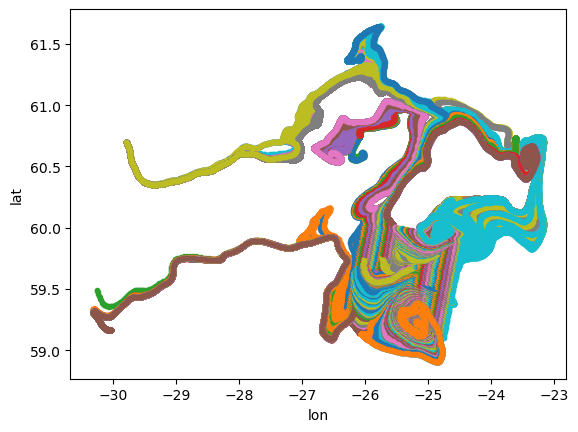

In [27]:
ds = xr.open_zarr(outputwavename)

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

In [29]:
ds

<xarray.Dataset> Size: 408MB
Dimensions:     (trajectory: 2500, obs: 2148)
Coordinates:
  * obs         (obs) int32 9kB 0 1 2 3 4 5 6 ... 2142 2143 2144 2145 2146 2147
  * trajectory  (trajectory) int64 20kB 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499
Data variables: (12/18)
    lat         (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    pi10        (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    pi100       (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    pi12        (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    pi16        (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    ...          ...
    pi60        (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    pi8         (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] 43MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    ue          (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    ve          (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 21MB dask.array<chunksize=(2500, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleSampleTAdvectionRK4CheckOutOfBounds
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [71]:
ds['time'][200,:].values

array([               0,    3600000000000,    7200000000000, ...,
       7722000000000000, 7725600000000000, 7729200000000000],
      dtype='timedelta64[ns]')

# animation

In [44]:
ds

<xarray.Dataset> Size: 17MB
Dimensions:     (trajectory: 289, obs: 2148)
Coordinates:
  * obs         (obs) int32 9kB 0 1 2 3 4 5 6 ... 2142 2143 2144 2145 2146 2147
  * trajectory  (trajectory) int64 2kB 3125 3126 3127 3128 ... 3411 3412 3413
Data variables:
    lat         (trajectory, obs) float32 2MB dask.array<chunksize=(289, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 2MB dask.array<chunksize=(289, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] 5MB dask.array<chunksize=(289, 1), meta=np.ndarray>
    ue          (trajectory, obs) float32 2MB dask.array<chunksize=(289, 1), meta=np.ndarray>
    ve          (trajectory, obs) float32 2MB dask.array<chunksize=(289, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 2MB dask.array<chunksize=(289, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleSampleTAdvectionRK4CheckOutOfBounds
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [45]:
ds['time'][70,:].values/1e9

array([      0,    3600,    7200, ..., 7722000, 7725600, 7729200],
      dtype='timedelta64[ns]')

/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


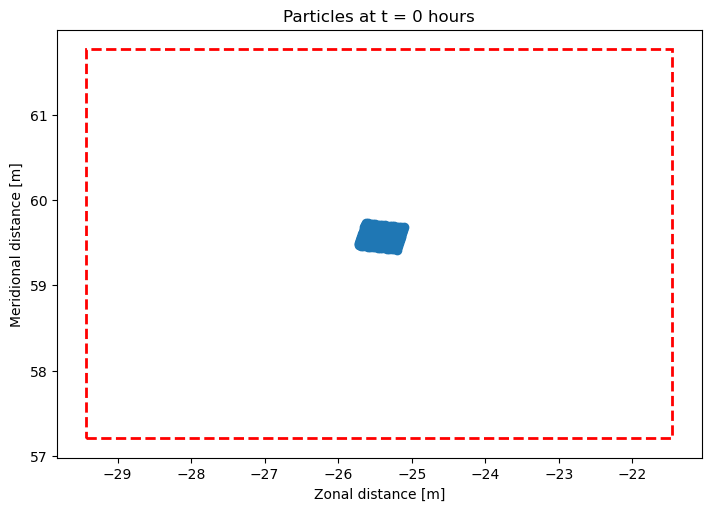

In [46]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches


lon_min = -30.92595646869225 + 1.5
lon_max = -19.9541352315797 - 1.5
lat_min = 56.70597152564239 + 0.5  # 注意：原条件是"+0.5"，但通常下限用减
lat_max = 62.267609501148414 - 0.5  # 原条件是"-0.5"，但通常上限用加

rect = patches.Rectangle(
    (lon_min, lat_min),         # 左下角坐标
    lon_max - lon_min,          # 宽度
    lat_max - lat_min,          # 高度
    linewidth=2, 
    edgecolor='r', 
    facecolor='none',           # 透明填充
    linestyle='--',             # 虚线边框
    label='Target Area'
)

# %% capture
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()
ax.add_patch(rect)

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")

# show only every fifth output (for speed in creating the animation)
timerange = np.unique(ds["time"].values)[::24]

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)



In [75]:
HTML(anim.to_jshtml())


/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/home/simingzhang/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/hom

In [48]:
lonp1.shape

(289,)

In [46]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from matplotlib.gridspec import GridSpec

# fig = plt.figure(figsize=(8, 4))
# gs = GridSpec(1, 1, width_ratios=[0.6])  # 宽度比例为 60%
# ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())

# ax.set_facecolor('grey')
# ax.coastlines(resolution='50m')
# ax.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
# ax.set_extent([lonmin, lonmax, latmin-2, latmax+2], crs=ccrs.PlateCarree())

# mesh = ax.pcolormesh(lon_rho.values, lat_rho.values, h.values,cmap=plt.cm.gist_earth_r,shading='gouraud',vmin=20,vmax=3000)
# plt.colorbar(mesh, ax=ax, label='Depth (m)')
# # ax.scatter(ds.lon, ds.lat, s=30, cmap="viridis", edgecolors="k")
# ax.plot(ds.lon.T, ds.lat.T, "-")


# ax.set_xticks([-30, -25, -20])
# ax.set_yticks([54, 59, 64])
# ax.set_xticklabels([f"${x}^\\degree$E" for x in [-30, -25, -20]])
# ax.set_yticklabels([f"${y}^\\degree$N" for y in [54, 59, 64]])
# plt.tight_layout()
# plt.show()

In [23]:
# ds.lat[:,1]
from tqdm import tqdm
survived_pars=np.zeros(ds.lat.values.shape[1])
TT=np.arange(ds.lat.values.shape[1])+1

for tt in tqdm(range(ds.lat.values.shape[1])):
    lat_values = ds.lat[:,tt].values
    total_pars=lonp1.shape
    died_pars=np.isnan(lat_values).sum()
    survived_pars[tt]=total_pars-died_pars
sequence = 240 * np.arange(1, 10)

  0%|                                                                               | 0/2148 [00:00<?, ?it/s]/tmp/ipykernel_3839208/3675675054.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  survived_pars[tt]=total_pars-died_pars
100%|███████████████████████████████████████████████████████████████████| 2148/2148 [00:03<00:00, 630.72it/s]


In [24]:
sequence

array([ 240,  480,  720,  960, 1200, 1440, 1680, 1920, 2160])

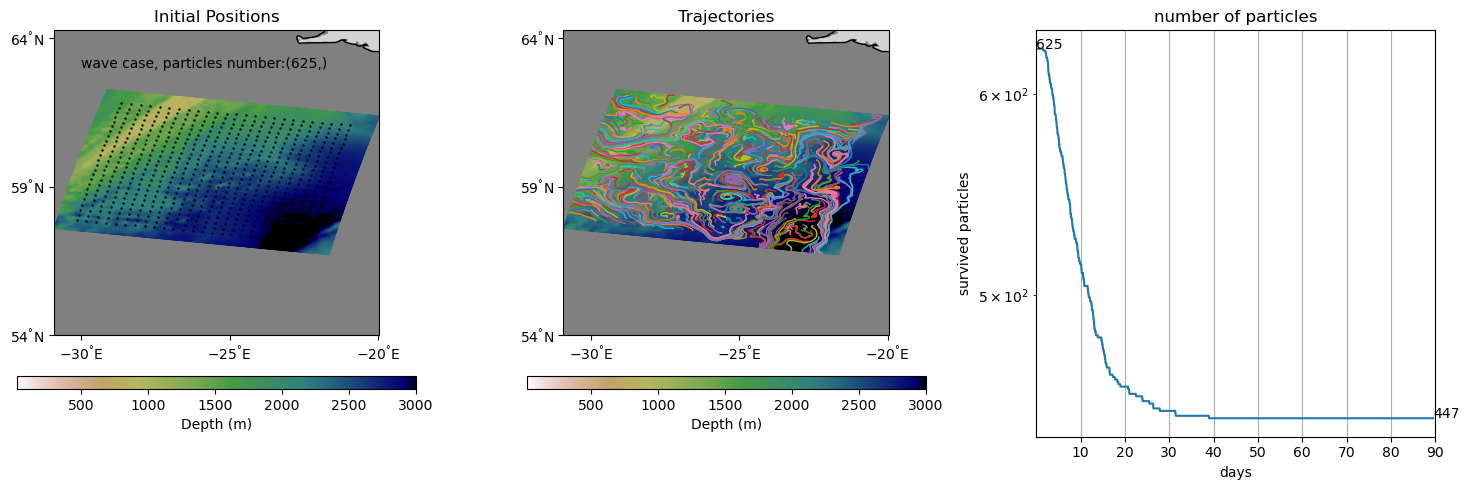

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 3, width_ratios=[1, 1, 1])  # 三列等宽

# 公用参数
extent = [lonmin, lonmax, latmin-2, latmax+2]

# 第一列：粒子初始位置 + 背景水深
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax1.set_facecolor('grey')
ax1.coastlines(resolution='50m')
ax1.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax1.set_extent(extent, crs=ccrs.PlateCarree())

# 添加背景水深
mesh1 = ax1.pcolormesh(lon_rho.values, lat_rho.values, h.values,
                      cmap=plt.cm.gist_earth_r, shading='gouraud', vmin=20, vmax=3000)
ax1.scatter(ds.lon.isel(obs=0), ds.lat.isel(obs=0), s=0.5, color='red',edgecolor='k')

cbar = plt.colorbar(mesh1, ax=ax1, orientation='horizontal',pad=0.1, aspect=30, shrink=1,label='Depth (m)')

ax1.set_title('Initial Positions')
ax1.text(-30,63,f'wave case, particles number:{total_pars}')

# 第二列：原始轨迹图
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax2.set_facecolor('grey')
ax2.coastlines(resolution='50m')
ax2.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax2.set_extent(extent, crs=ccrs.PlateCarree())

mesh2 = ax2.pcolormesh(lon_rho.values, lat_rho.values, h.values,
                      cmap=plt.cm.gist_earth_r, shading='gouraud', vmin=20, vmax=3000)
ax2.plot(ds.lon.T, ds.lat.T, "-", linewidth=1)
cbar = plt.colorbar(mesh1, ax=ax2, orientation='horizontal',pad=0.1, aspect=30, shrink=1,label='Depth (m)')
ax2.set_title('Trajectories')

# 第三列：空白图
ax3 = fig.add_subplot(gs[2])
# ax3.plot(survived_pars)
ax3.semilogy(TT,survived_pars)
# plt.semilogy(TT,)
ax3.text(TT[0],survived_pars[0],f'{int(survived_pars[0])}')
ax3.text(TT[-1],survived_pars[-1],f'{int(survived_pars[-1])}')
ax3.set_xlim([TT[0],TT[-1]])
ax3.set_xticks(sequence)
ax3.set_xticklabels(['10','20','30','40','50','60','70','80','90'])
ax3.set_xlabel('days')
ax3.set_ylabel('survived particles')
ax3.set_title('number of particles')


ax3.grid(True)

# 统一坐标轴设置
for ax in [ax1, ax2]:
    ax.set_xticks([-30, -25, -20])
    ax.set_yticks([54, 59, 64])
    ax.set_xticklabels([f"${x}^\\degree$E" for x in [-30, -25, -20]])
    ax.set_yticklabels([f"${y}^\\degree$N" for y in [54, 59, 64]])

plt.tight_layout()
plt.savefig(f'/meddy/simingzhang/Data/Figure/{outputwavename[37:-5]}.png',dpi=300, bbox_inches='tight')

plt.show()

In [26]:
tin=20
ds['lon'][tin,0].values,ds['lat'][tin,0].values

(array(-23.661827, dtype=float32), array(57.258804, dtype=float32))

In [27]:
spheric_dist_one(ds['lat'][tin-1,0].values,ds['lat'][tin,0].values,ds['lon'][tin-1,0].values,ds['lon'][tin,0].values),20000/3600

(19.660737180501474, 5.555555555555555)

In [30]:
f'{outputwavename[37:-5]}.nc'

'wave_pars_P2500T89.5days.nc'

In [ ]:
ds.to_netcdf(f'{outputwavename[:-5]}.nc')

In [31]:
ds

<xarray.Dataset> Size: 38MB
Dimensions:     (trajectory: 625, obs: 2148)
Coordinates:
  * obs         (obs) int32 9kB 0 1 2 3 4 5 6 ... 2142 2143 2144 2145 2146 2147
  * trajectory  (trajectory) int64 5kB 0 1 2 3 4 5 6 ... 619 620 621 622 623 624
Data variables:
    lat         (trajectory, obs) float32 5MB dask.array<chunksize=(625, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 5MB dask.array<chunksize=(625, 1), meta=np.ndarray>
    time        (trajectory, obs) timedelta64[ns] 11MB dask.array<chunksize=(625, 1), meta=np.ndarray>
    ue          (trajectory, obs) float32 5MB dask.array<chunksize=(625, 1), meta=np.ndarray>
    ve          (trajectory, obs) float32 5MB dask.array<chunksize=(625, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 5MB dask.array<chunksize=(625, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleSampleTAdvectionRK4CheckOutOfBounds
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [184]:
outputwavename

'/meddy/simingzhang/Data/Parcels_data/wave_pars_P289T89.5days.zarr'

# Parcel
### 2. no wave case

In [13]:
nowavename
filenames = {"U": nowavename, "V": nowavename}
filenames



{'U': '/meddy/simingzhang/Data/Parcels_data/nowavecase_modified.nc',
 'V': '/meddy/simingzhang/Data/Parcels_data/nowavecase_modified.nc'}

In [14]:
variables = {
    "U": "u_rho",
    "V": "v_rho",
}
dimensions = {
    "U": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
    "V": {"lat": "lat_rho", "lon": "lon_rho", "time": "time"},
}
# fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions,allow_time_extrapolation=True)
fieldset = parcels.FieldSet.from_a_grid_dataset(filenames, variables, dimensions,allow_time_extrapolation=True,gridindexingtype="mitgcm")
fieldset.U.grid.time *= 3600  # 秒 → 小时


In [15]:
lonp=lon_rho.values
latp=lat_rho.values
# Range=20
# JJ=[Range,287-Range]
# II=[Range,287-Range]
# step=1
# lonp1=lonp[JJ[0]:JJ[1]:step,II[0]:II[1]:step].ravel()
# latp1=latp[JJ[0]:JJ[1]:step,II[0]:II[1]:step].ravel()
step=1
centerpoint=144
# npart=2500
npart=17*17
if (np.sqrt(npart) / 2) % 1 == 0:
    left1=int(np.sqrt(npart)/2)
    right1=int(np.sqrt(npart)/2)
    # print(1)
else:
    left1=int((np.sqrt(npart)+1)/2)
    right1=int((np.sqrt(npart)+1)/2)-1
    # print(2)
II=[centerpoint-left1,centerpoint+right1]
JJ=[centerpoint-left1,centerpoint+right1]
lonp1=lonp[JJ[0]:JJ[1]:step,II[0]:II[1]:step].ravel()
latp1=latp[JJ[0]:JJ[1]:step,II[0]:II[1]:step].ravel()
during=89.5 # days
total_seconds = during * 86400 
outputnowavename=f'{wave_dir}nowave_pars_P{latp1.shape[0]}T{during}days.zarr'

In [16]:
lonp1.shape

(289,)

In [17]:
def DeleteParticle(particle, fieldset, time):
    if (particle.lon < -30.92595646869225+1.5) or (particle.lon > -19.9541352315797-1.5) or \
       (particle.lat < 56.70597152564239+0.5) or (particle.lat > 62.267609501148414-0.5):
        particle.delete()
        
def SampleT(particle, fieldset, time):
    particle.ue = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    particle.ve = fieldset.V[time, particle.depth, particle.lat, particle.lon]

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [18]:
# pset = parcels.ParticleSet.from_list(
#     fieldset=fieldset,
#     pclass=parcels.JITParticle,
#     lon=lonp1,
#     lat=latp1,
#     # size=100,                # 粒子总数
#     depth=-2*np.ones(lonp1.shape)                  # 释放深度
# )



# output_file = pset.ParticleFile(
#     name=outputnowavename, outputdt=timedelta(hours=1)
# )

# pset.execute(
#     [DeleteParticle,parcels.AdvectionRK4],  # simply combine the Kernels in a list
#     runtime=timedelta(seconds=total_seconds),
#     dt=timedelta(minutes=60),
#     output_file=output_file,
# )


pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=parcels.JITParticle.add_variable("ue").add_variable("ve"),
    lon=lonp1,
    lat=latp1,
    # size=100,                # 粒子总数
    depth=-2*np.ones(lonp1.shape)                  # 释放深度
)



output_file = pset.ParticleFile(
    name=outputnowavename, outputdt=timedelta(hours=1)
)

pset.execute(
    [SampleT,parcels.AdvectionRK4,CheckOutOfBounds],  # simply combine the Kernels in a list
    runtime=timedelta(hours=2148),
    dt=timedelta(seconds=600),
    output_file=output_file,
)

/home/simingzhang/anaconda3/lib/python3.12/site-packages/parcels/field.py:1180: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /meddy/simingzhang/Data/Parcels_data/nowave_pars_P289T89.5days.zarr.
100%|████████████████████████████████████████████████████████| 7732800.0/7732800.0 [46:50<00:00, 2751.60it/s]


In [19]:
ds = xr.open_zarr(outputnowavename)

In [20]:
from tqdm import tqdm
survived_pars=np.zeros(ds.lat.values.shape[1])
TT=np.arange(ds.lat.values.shape[1])+1

for tt in tqdm(range(ds.lat.values.shape[1])):
    lat_values = ds.lat[:,tt].values
    total_pars=lonp1.shape
    died_pars=np.isnan(lat_values).sum()
    survived_pars[tt]=total_pars-died_pars
sequence = 240 * np.arange(1, 10)

  0%|                                                                               | 0/2148 [00:00<?, ?it/s]/tmp/ipykernel_238795/4050879142.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  survived_pars[tt]=total_pars-died_pars
100%|███████████████████████████████████████████████████████████████████| 2148/2148 [00:14<00:00, 153.37it/s]


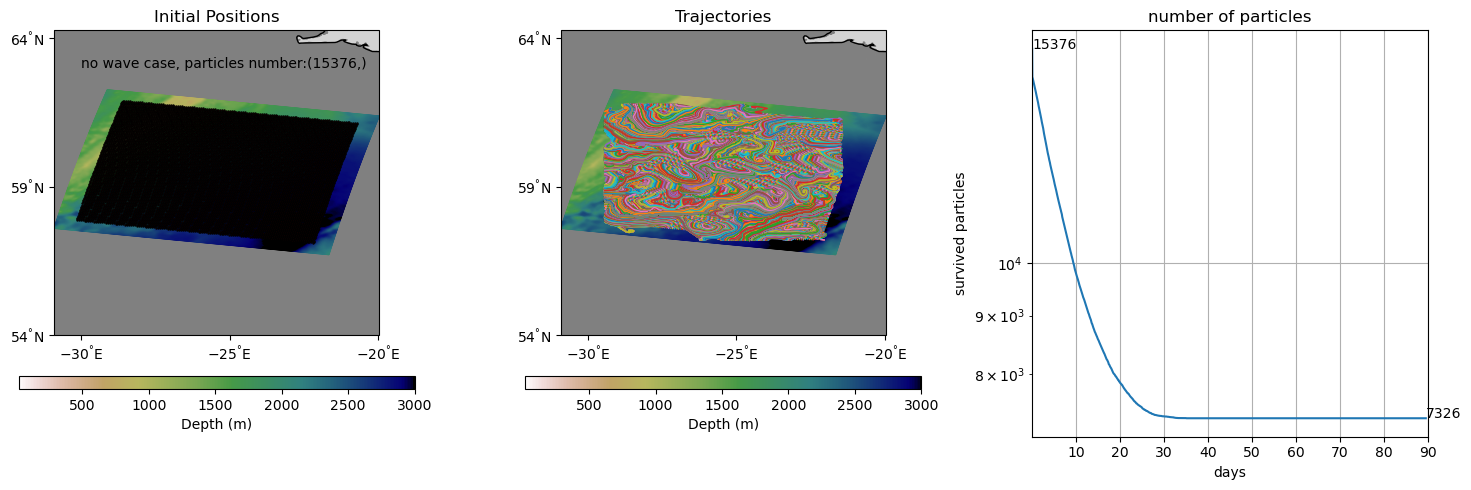

In [118]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 3, width_ratios=[1, 1, 1])  # 三列等宽

# 公用参数
extent = [lonmin, lonmax, latmin-2, latmax+2]

# 第一列：粒子初始位置 + 背景水深
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax1.set_facecolor('grey')
ax1.coastlines(resolution='50m')
ax1.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax1.set_extent(extent, crs=ccrs.PlateCarree())

# 添加背景水深
mesh1 = ax1.pcolormesh(lon_rho.values, lat_rho.values, h.values,
                      cmap=plt.cm.gist_earth_r, shading='gouraud', vmin=20, vmax=3000)
ax1.scatter(ds.lon.isel(obs=0), ds.lat.isel(obs=0), s=0.5, color='red',edgecolor='k')

cbar = plt.colorbar(mesh1, ax=ax1, orientation='horizontal',pad=0.1, aspect=30, shrink=1,label='Depth (m)')

ax1.set_title('Initial Positions')
ax1.text(-30,63,f'no wave case, particles number:{total_pars}')

# 第二列：原始轨迹图
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax2.set_facecolor('grey')
ax2.coastlines(resolution='50m')
ax2.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax2.set_extent(extent, crs=ccrs.PlateCarree())

mesh2 = ax2.pcolormesh(lon_rho.values, lat_rho.values, h.values,
                      cmap=plt.cm.gist_earth_r, shading='gouraud', vmin=20, vmax=3000)
ax2.plot(ds.lon.T, ds.lat.T, "-", linewidth=1)
cbar = plt.colorbar(mesh1, ax=ax2, orientation='horizontal',pad=0.1, aspect=30, shrink=1,label='Depth (m)')
ax2.set_title('Trajectories')

# 第三列：空白图
ax3 = fig.add_subplot(gs[2])
# ax3.plot(survived_pars)
ax3.semilogy(TT,survived_pars)
# plt.semilogy(TT,)
ax3.text(TT[0],survived_pars[0],f'{int(survived_pars[0])}')
ax3.text(TT[-1],survived_pars[-1],f'{int(survived_pars[-1])}')
ax3.set_xlim([TT[0],TT[-1]])
ax3.set_xticks(sequence)
ax3.set_xticklabels(['10','20','30','40','50','60','70','80','90'])
ax3.set_xlabel('days')
ax3.set_ylabel('survived particles')
ax3.set_title('number of particles')


ax3.grid(True)

# 统一坐标轴设置
for ax in [ax1, ax2]:
    ax.set_xticks([-30, -25, -20])
    ax.set_yticks([54, 59, 64])
    ax.set_xticklabels([f"${x}^\\degree$E" for x in [-30, -25, -20]])
    ax.set_yticklabels([f"${y}^\\degree$N" for y in [54, 59, 64]])

plt.tight_layout()
plt.savefig(f'/meddy/simingzhang/Data/Figure/{outputnowavename[37:-5]}.png',dpi=300, bbox_inches='tight')

plt.show()

In [21]:
ds.to_netcdf(f'{outputnowavename[:-5]}.nc')

NameError: name 'u_rho' is not defined